<AxesSubplot: xlabel='Date'>

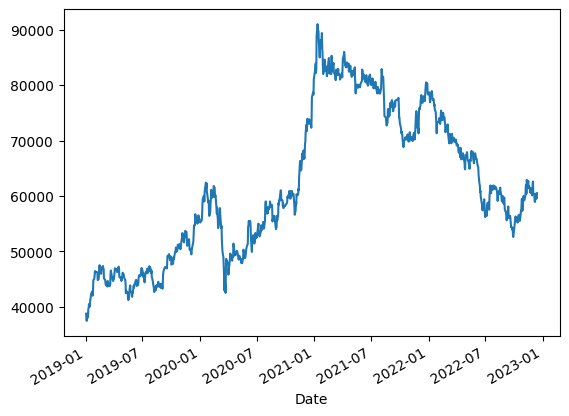

In [4]:
import FinanceDataReader as fdr

df_krx = fdr.StockListing("KRX")

#print(df_krx)

df = fdr.DataReader('005930', '2019')
df['Close'].plot()

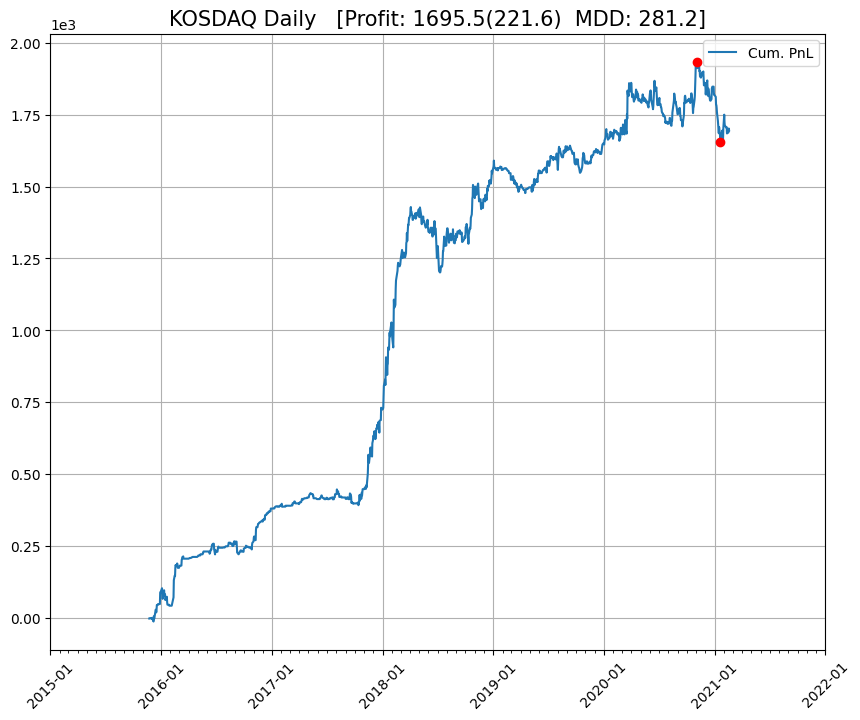

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox
from matplotlib.widgets import RadioButtons
from datetime import timedelta
import matplotlib.ticker as ticker

plt.rcParams["figure.dpi"] = 100
years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y-%m')


# 손절 비율 0.9/100 = 0.9%
lc = 0.9 / 100

# 종목 정보 딕셔너리 데이타형 사용함, 코스피 선물과 코스닥 선물
Mkt_Info = {'KFD': {'term': 'Daily', 'point value': 25, 'Item': 'KOSPI200', 'Tick': 1.25, 'Margin': 0.12, 'ex': 1},
            'KFW': {'term': 'Weekly', 'point value': 25, 'Item': 'KOSPI200', 'Tick': 1.25, 'Margin': 0.12, 'ex': 1},
            'KQD': {'term': 'Daily', 'point value': 1, 'Item': 'KOSDAQ', 'Tick': 0.1, 'Margin': 0.15, 'ex': 1},
            'KQW': {'term': 'Weekly', 'point value': 1, 'Item': 'KOSDAQ', 'Tick': 0.1, 'Margin': 0.15, 'ex': 1},
            }


# csv file 읽어오기 D:\GOM37\Data는 보고자 하는 파일이 있는 폴더임
# 파일 이름은 세글자(대문자)로 통일함

file_str = r'/workspace/PythonTrader/KQD.csv'

temp = file_str[-7:-4]
title_str = Mkt_Info[temp]['Item'] + ' ' + Mkt_Info[temp]['term']

# pv : point value, Kospi 선물 pv =25  Kosdaq 선물 pv = 1, 전부 1만원 다위
pv = Mkt_Info[temp]['point value']
# 한틱 가치: 코스피 선물: 1.25, 코스닥 선물: 0.1
slippage = Mkt_Info[temp]['Tick']
# 총 비용을 구할 때 사용
# 코스피 m = 1.5, 코스닥 m = 6
m = 6

# 데이타프레임 df로 일별 데이터 읽어 들이기
df = pd.read_csv(file_str)
# csv 파일의 텍스트로 된 날짜를 datetime으로 변환: 필수!!
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# df_trades = pd.DataFrame(np.zeros((len(df), acc_num)), index=df.index)
# 코딩을 편리하게 하기 위해 시가, 고가, 저가, 종가 변수를 Op, Hi, Lo, Cl로 바꿈
Op = df['Open']
Hi = df['High']
Lo = df['Low']
Cl = df['Close']

# 데이타프레임 df에 거래 손익, 누적 손익을 추가, 0으로 초기화
df['Buy_Line'] = df['Open']*(1+lc)
df['Sell_Line'] = df['Open']*(1-lc)
BL = df['Buy_Line']
SL = df['Sell_Line']
df['Pnl'] = np.zeros(len(df))
df['cum_Pnl'] = np.zeros(len(df))

# 주요 로직
# Hi > BL, Lo > SL
# (고가 > 매수선) 그리고 (저가 > 매도선)
# 매수선(BL = Op*(1+lc))에서 매수 후 종가(Cl) 청산
df.loc[(Hi > BL) & (Lo > SL), 'Pnl'] = pv*(Cl - BL) - m*slippage

# Hi > BL, Lo < SL
# (고가 > 매수선) 그리고 (저가 < 매도선)
# 손절: -(BL - SL) = -(Op*(1+lc) -Op*(1-lc) = -2*Op*lc
df.loc[(Hi > BL) & (Lo < SL), 'Pnl'] = -pv*(BL - SL) - m*slippage

# Hi < BL, Lo > SL
# (고가 < 매수선) 그리고 (저가 > 매도선)
# 매매 없음
df.loc[(Hi < BL) & (Lo > SL), 'Pnl'] = 0

# Hi < BL, Lo < SL
# (고가 < 매수선) 그리고 (저가 < 매도선)
# 매도선(SL = Op*(1-lc))에서 매도 후 종가(Cl) 청산
df.loc[(Hi < BL) & (Lo < SL), 'Pnl'] = pv*(SL - Cl) - m*slippage

# 누적 손익 구하기
df['cum_Pnl'] = df['Pnl'].cumsum()

# 차트 그리기
fig, axs = plt.subplots(figsize=(10, 8))
axs.grid()

# 차트 x 축 설정(년 단위)
axs.xaxis.set_major_locator(years)
axs.xaxis.set_major_formatter(years_fmt)
axs.xaxis.set_minor_locator(months)

datemin = np.datetime64(df.index[0], 'Y')
datemax = np.datetime64(df.index[-1], 'Y') + np.timedelta64(1, 'Y')
# 거래 일수를 년으로 환산
num_days = (df.index[-1] - df.index[0])
num_years = num_days/np.timedelta64(1, 'D')/250

axs.set_xlim(datemin, datemax)

# x 축 레이블을 45도 회전
plt.setp(axs.xaxis.get_majorticklabels(), rotation=45)
axs.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
axs.plot(df.index, df['cum_Pnl'], linewidth=1.5, label='Cum. PnL')

# MDD 구하기
accum = df['cum_Pnl']
ii = np.argmax((np.maximum.accumulate(accum) - accum))  # end of the period
jj = np.argmax(accum[:ii])  # start of period
mdd = accum[jj] - accum[ii]

# MDD를 챠트에 그리기(두 점으로 나타냄)
axs.plot([df.index[ii], df.index[jj]], [accum[ii], accum[jj]], 'o', color='Red', markersize=6)

# 전체 수익
txt_trade = "[Profit: " + "{:.1f}".format(df['cum_Pnl'][-1])
# 연평균 수익
txt_trade = txt_trade + "(" + "{:.1f}".format(df['cum_Pnl'][-1]/num_years)+ ")"
# MDD
txt_trade = txt_trade + "  " + "MDD: " + "{:.1f}".format(mdd) + "]"
axs.set_title(title_str + "   " + txt_trade, fontsize=15)

axs.legend()
plt.show()
